In [1]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import gcsfs
import warnings
warnings.filterwarnings('ignore')
import sklearn
from scipy.stats import linregress

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from pprint import pprint
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### **Load datasets**

In [3]:
# load 2020 dataset
df_storms_2020 = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/IPL_Master_Dataset/OMS_All_Storm.csv')
df_nov_stroms = pd.read_csv("gs://aes-datahub-0002-curated/Outage_Restoration/IPL_Master_Dataset/OMS_15thNov_Storm.csv")
df_final = df_storms_2020.append(df_nov_stroms)


# load features dataset for catboost & random forest 
df_catboost_features = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Model/IPL_TTR_Catboost_11272020.csv')
df_rf_features = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Model_object/Random_Forest_GridSearch_09172020.csv', index_col=False)

In [4]:
df_final = df_final.dropna(axis=0, subset=['Slope_outages', 'Slope_ROC_outages'])

#### **Load Model Objects**

In [5]:
rf_model = pd.read_pickle('gs://aes-analytics-0002-curated/Outage_Restoration/Model_object/Random_Forest_GridSearch_09172020.pkl')
    
catboost_model = pd.read_pickle('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/IPL_TTR_Catboost_11272020.pkl')

In [6]:
cat_final_features = list(df_catboost_features.Features.unique())
print(len(cat_final_features))
print(cat_final_features)
print('\n')

40
['Time_Since_Outage', 'Priority_Customer_Qty', 'CALL_QTY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'LIVE_OUTAGE', 'Outages_in_last_1hr', 'CUST_QTY', 'DOWNSTREAM_CUST_QTY', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'Dis_From_Live_Centriod_div_Cust_qty', 'Outages_in_last_2hr', 'precip', 'weight_ROC', 'max_ROC_outages', 'Outages_in_last_5hr', 'Outages_in_last_4hr', 'DNI_EQUIP_TYPE', 'windSpdRange', 'Hour_Cos', 'PRIORITY_VAL_1.0', 'windSpdMax', 'tempRange', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'Outages_in_last_3hr', 'windSpd100mMax', 'Slope_ROC_outages', 'Hour_Sin', 'relHumRange', 'dewPtMax', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'ZONE', 'Outages_in_last_10hr', 'TREE_CAUSE_FLG', 'Outages_in_last_6hr', 'windSpdAvg', 'Slope_outages', 'FUSE_OCCURN_FLG']




In [7]:
rf_final_feautres = list(df_rf_features.Features_List.unique())
print(list(df_rf_features.Features_List.unique()))

['windDir100mAvg', 'POWER_OUT_CLUE_FLG_True', 'Hour_Cos', 'FUSE_OCCURN_FLG_False', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'Outages_in_last_1hr', 'Priority_Customer_Qty', 'ANIMAL_CAUSE_FLG_False', 'UG_CAUSE_FLG_False', 'tempRange', 'NO_OF_WIRE_OCCURN_PER_DAY', 'radSolarTot', 'PUBLIC_SAFETY_OCCURN_FLG_True', 'Outages_in_last_10hr', 'NO_CAUSE_FLG_False', 'cldCvrRange', 'windSpd80mMax', 'Hour_Sin', 'CALL_QTY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'TREE_CAUSE_FLG_True', 'Outages_in_last_2hr', 'TREE_CAUSE_FLG_False', 'Priority_Dist_Customer_Qty', 'relHumAvg', 'POLE_CLUE_FLG_False', 'DOWNSTREAM_CUST_QTY', 'Outages_in_last_9hr', 'heatIndexMax', 'DAY_FLAG_True', 'WIRE_OCCURN_FLG_False', 'ANIMAL_CAUSE_FLG_True', 'ST_OCCURN_FLG_False', 'CITY_NAM_NO_CITY', 'PUBLIC_SAFETY_OCCURN_FLG_False', 'ST_OCCURN_FLG_True', 'POWER_OUT_CLUE_FLG_False']


In [8]:
storm_df = df_final.copy(deep=True)
storm_df = pd.get_dummies(df_final, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [9]:
storm_df = storm_df[storm_df.TTR>30]
storm_df = storm_df[storm_df.TTR<5000]
df_final = df_final[df_final.TTR>30]
df_final = df_final[df_final.TTR<5000]

In [10]:
storm_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
storm_result_df = pd.DataFrame(columns=storm_col)
storm_test_list = pd.DataFrame() 
i=0

In [11]:
X = storm_df[rf_final_feautres]
y = np.log(storm_df.TTR)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest Storms', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['Random Forest Storms', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [12]:
storm_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Storms,126631.34,355.85,264.33,154.31,0.37


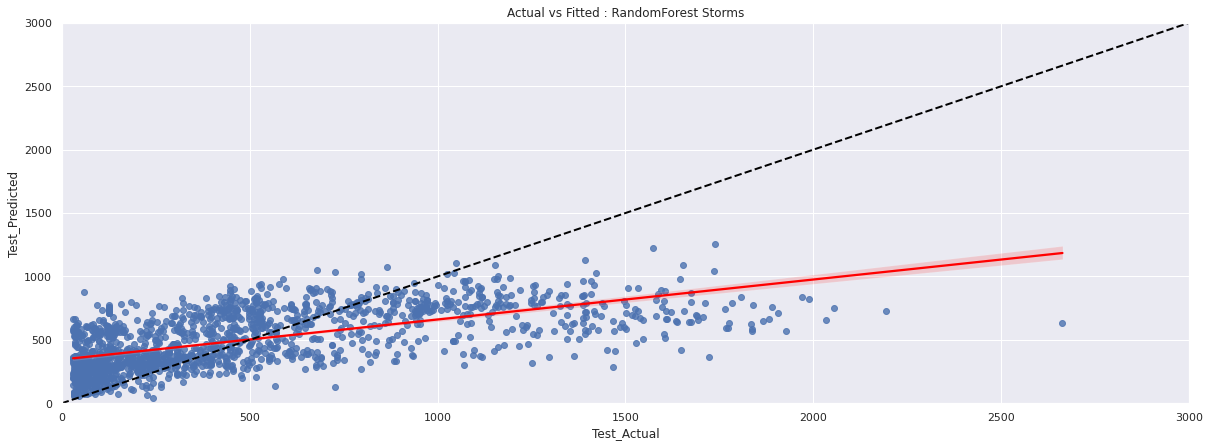

In [13]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list[storm_test_list.Model=='Random Forest Storms'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : RandomForest Storms')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

In [14]:
df_final['Time_Since_Outage'] = 0
ads_v1 = df_final[cat_final_features]
ads_v1['TTR'] = df_final['TTR']
display(ads_v1.head())

,Time_Since_Outage,Priority_Customer_Qty,CALL_QTY,NO_OF_WIRE_OCCURN_PER_DAY,NO_OF_POWER_OUT_CLUE_PER_DAY,LIVE_OUTAGE,Outages_in_last_1hr,CUST_QTY,DOWNSTREAM_CUST_QTY,Priority_Dist_Customer_Qty,Dispatch_Location,Dis_From_Live_Centriod_div_Cust_qty,Outages_in_last_2hr,precip,weight_ROC,max_ROC_outages,Outages_in_last_5hr,Outages_in_last_4hr,DNI_EQUIP_TYPE,windSpdRange,Hour_Cos,PRIORITY_VAL_1.0,windSpdMax,tempRange,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,Outages_in_last_3hr,windSpd100mMax,Slope_ROC_outages,Hour_Sin,relHumRange,dewPtMax,Outages_in_last_7hr,Outages_in_last_8hr,ZONE,Outages_in_last_10hr,TREE_CAUSE_FLG,Outages_in_last_6hr,windSpdAvg,Slope_outages,FUSE_OCCURN_FLG,TTR
0,0,6.00,13,15,206,3,1,20,20,12.00,MILL,0.33,1,0.47,2.00,10,14,14,FUSE,12.60,1.00,False,13.10,15.30,0,11,24.50,0.10,0.00,26.00,75.30,21,24,ZONE4,35,False,16,7.70,0.25,True,67.93
1,0,11.00,4,15,206,4,2,12,12,22.00,ARL.,0.77,2,0.54,3.60,12,15,14,1TPUG,11.40,1.00,True,12.30,17.00,0,2,24.00,0.22,0.00,25.00,75.00,21,24,ZONE3,36,False,16,7.60,0.25,False,44.62
2,0,18.00,1,15,206,5,3,3,3,34.00,ENGLISH,3.66,3,0.55,3.60,12,16,15,1TPUG,11.10,1.00,False,11.20,21.30,0,3,23.10,0.22,0.00,32.90,73.80,21,25,ZONE3,37,False,16,6.10,0.26,False,40.17
3,0,20.00,1,15,206,3,2,1,1,39.00,ARL.,9.92,4,0.45,4.80,12,16,4,1TPUG,9.60,0.97,False,11.30,19.00,0,4,23.30,0.17,0.26,28.00,74.70,18,23,ZONE3,31,False,17,7.20,0.28,False,79.20
4,0,8.00,4,15,206,3,0,17,17,11.00,MILL,0.30,0,0.41,2.20,11,13,13,PADELB,12.60,1.00,False,13.80,15.70,0,11,23.90,0.04,0.00,24.50,75.20,21,23,ZONE4,34,False,16,8.80,0.25,True,122.60


In [15]:
len(list(ads_v1.columns))

41

In [16]:
X = ads_v1.drop(['TTR'], axis=1)
y = ads_v1.TTR

y_test_pred = catboost_model.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['CatBoost', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [17]:
storm_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Storms,126631.34,355.85,264.33,154.31,0.37
1,CatBoost,228562.49,478.08,386.43,244.96,-0.13


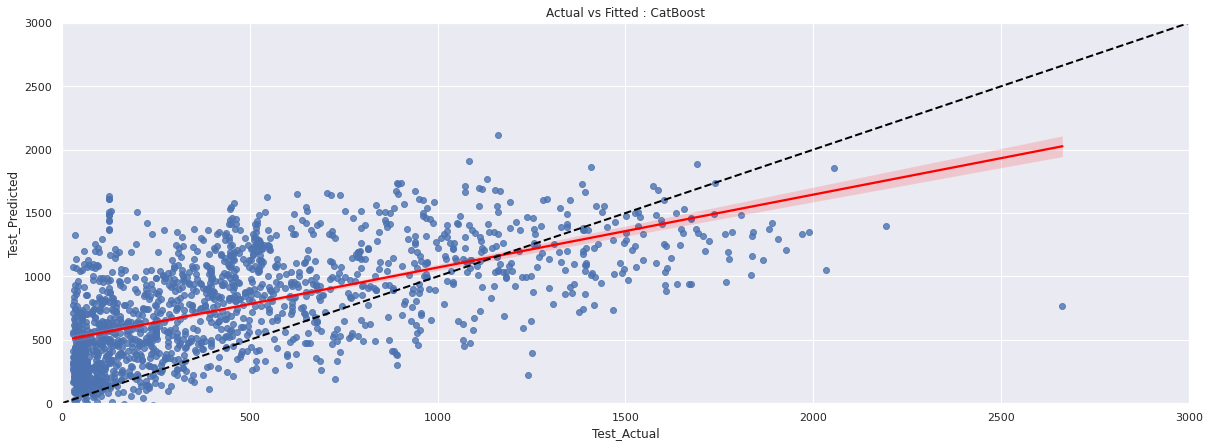

In [18]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list[storm_test_list.Model=='CatBoost'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CatBoost')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

In [19]:
ads_v1['Time_Since_Outage'] = 60

In [20]:
X = ads_v1.drop(['TTR'], axis=1)
y = ads_v1.TTR

y_test_pred = catboost_model.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost_60', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['CatBoost_60', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [21]:
storm_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Storms,126631.34,355.85,264.33,154.31,0.37
1,CatBoost,228562.49,478.08,386.43,244.96,-0.13
2,CatBoost_60,204073.80,451.75,359.67,223.21,-0.01


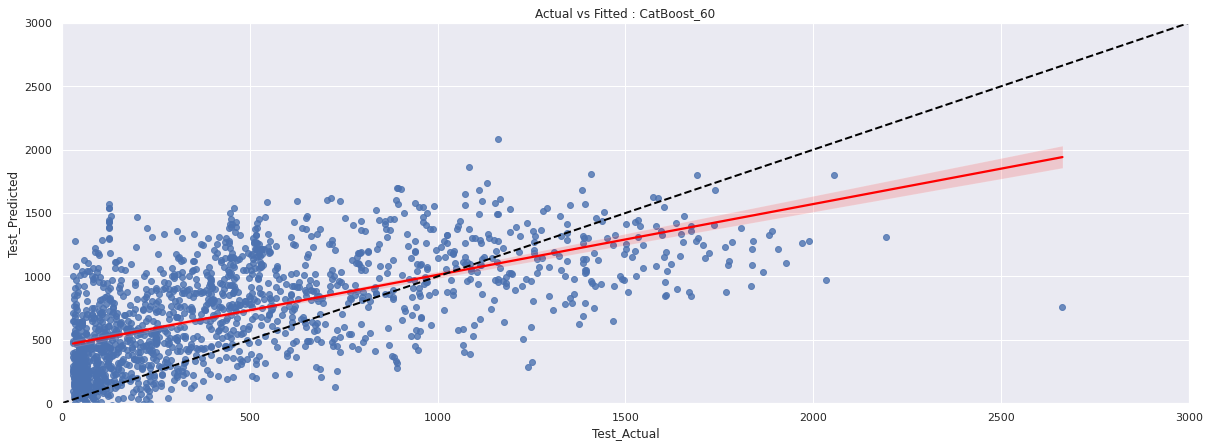

In [22]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list[storm_test_list.Model=='CatBoost_60'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CatBoost_60')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

In [23]:
storm_test_list.Model.unique()

array(['Random Forest Storms', 'CatBoost', 'CatBoost_60'], dtype=object)

In [24]:
storm_test_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/IPL_Master_Dataset/CatBoost_Storms.csv', index=False)